<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
    <h3>ML for Developers</h3>
    Design · Develop · Deploy · Iterate
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-40K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/agusabdulrahman/made-with-ml"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/agusabdulrahman"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/agusahn"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/agusabdulrahman/made-with-ml" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr>

This notebooks contains the code for the 🔢&nbsp; Data and 📈&nbsp; Modeling lessons. After this proof of concept (PoC), we'll be moving all of this code to Python scripts to serve our application to production. Follow the accompanying [lessons](https://madewithml.com/) along with the code here to develop a deeper understanding of all the concepts.

<div align="left">
<a target="_blank" href="https://madewithml.com/"><img src="https://img.shields.io/badge/📖 Read-lessons-9cf"></a>&nbsp;
<a href="https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# 🛠️ Setup

We'll be using Ray to develop our application using distributed workloads.

In [24]:
import os
import ray

In [5]:
import sys; sys.path.append("..")



In [11]:
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2


In [14]:
# initial Ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-07-02 07:20:06,854	INFO worker.py:1762 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.10
Ray version:,2.31.0
Dashboard:,http://127.0.0.1:8266


In [15]:
ray.cluster_resources()

{'CPU': 2.0,
 'object_store_memory': 637226188.0,
 'node:127.0.0.1': 1.0,
 'node:__internal_head__': 1.0,
 'memory': 1274452379.0}

These cluster resources only reflect our head node ([m5.2xlarge](https://instances.vantage.sh/aws/ec2/m5.2xlarge)). But recall in our [setup lesson](https://madewithml.com/courses/mlops/setup/) that our [compute configuration](https://madewithml.com/courses/mlops/setup/#compute) that we also added [g4dn.xlarge](https://instances.vantage.sh/aws/ec2/g4dn.xlarge) worker nodes (each has 1 GPU and 4 CPU) to our cluster. But because we set `min_workers=0`, our worker nodes will autoscale ( up to `max_workers`) as they're needed for specific workloads (ex. training). 

If you are running this on local laptop (no GPU), use the CPU count from `ray.cluster_resources` to set your resources. For example if you machine has 10 CPUs:

```python
num_worker =  6 # prefer to do a few less then total avaibel CPU (a for head note + 1 for backroudn tasks)
resources_per_worker={"CPU": 1, "GPU": 0}

```

In [16]:
# Worker (1 g4dn.xlarge)
num_workers =1 
resources_per_worker={"CPU": 1, "GPU": 0}

In [27]:
from dotenv import load_dotenv
load_dotenv()


True

In [28]:
# Storage
EFS_DIR = f"/efs/shared_storage/madewithml/{os.environ['GITHUB_USERNAME']}"
print(EFS_DIR)

/efs/shared_storage/madewithml/agusabdulrahman


# Data

## 🔢 Data ingestion

In [34]:
import pandas as pd

In [35]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/agusabdulrahman/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## ✂️ Data splitting

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [39]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [40]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [41]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size)/test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## 🔍 Exploratory Data Analysis (EDA)

Exporatory data analysis to understand the signals and nuaces of our dataset. It's a cyclical proces that can be done at various points of our development process (before/after labeling, processing, etc). depending on how well the problem is defined.

In [44]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [45]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

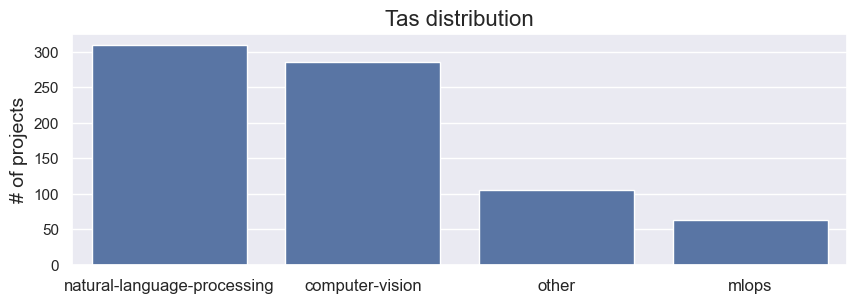

In [46]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tas distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

> We'll address the [data imbalance](https://madewithml.com/courses/mlops/baselines#data-imbalance) after splitting into our train split and prior to training our model.

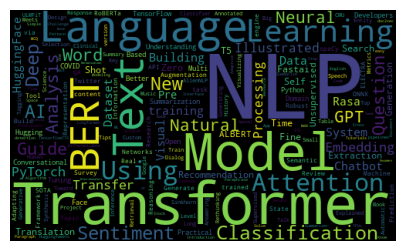

In [56]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300
).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like `title` text feature has some good signal for the respentive classes and matches our intuition. We can repeat this for the `description` text features as well. this information will become useful when we decide how to use our features for modeling.

## ✨ Data Preprocessing